### 1. Create dataset

In [5]:
# import packages
import pandas as pd
import numpy as np

In [384]:
# read csvs
idols = pd.read_csv("C:/Users/brant/Google Drive/extra study/ Kpop Data Analysis/K-pop 1992-2020/kpop_idols.csv")
boy_groups = pd.read_csv("C:/Users/brant/Google Drive/extra study/ Kpop Data Analysis/K-pop 1992-2020/kpop_boy_groups.csv")
girl_groups = pd.read_csv("C:/Users/brant/Google Drive/extra study/ Kpop Data Analysis/K-pop 1992-2020/kpop_girl_groups.csv")
mv = pd.read_csv("C:/Users/brant/Google Drive/extra study/ Kpop Data Analysis/K-pop 1992-2020/kpop_music_videos.csv")

In [385]:
# join files
groups = pd.concat([boy_groups,girl_groups])
idols_groups = pd.merge(idols, groups,left_on="Group",right_on="Name",how="inner")
idols_groups_songs = pd.merge(idols_groups, mv,left_on="Group",right_on="Artist",how="inner")

In [386]:
idols_groups_songs = idols_groups_songs[["Stage Name","Date of Birth","Group","Country","Debut","Members","Song Name"]]

In [387]:
# get debut age

idols_groups_songs["Debut"] = pd.to_datetime(idols_groups_songs["Debut"])
idols_groups_songs["Date of Birth"] = pd.to_datetime(idols_groups_songs["Date of Birth"])
idols_groups_songs["Debut Age"] = idols_groups_songs["Debut"] - idols_groups_songs["Date of Birth"]

idols_groups_songs["Debut Age"] = idols_groups_songs["Debut Age"].dt.days/365

In [388]:
# group by groups

# get # of members, # of songs and debut age
group_metric = idols_groups_songs.groupby('Group',as_index=False).agg({
    'Stage Name':'nunique','Song Name':'nunique','Debut Age':'mean'})

In [389]:
# get country%
table = pd.pivot_table(idols_groups_songs, values='Stage Name', index='Group',
                    columns=['Country'], aggfunc='nunique', fill_value=0)
table["Total"] = table.sum(axis=1)
table["Foreigner"] = 1-table["South Korea"]/table["Total"]

group_country = table['Foreigner'].reset_index()

In [390]:
# join group metric and country%

group_metric = pd.merge(group_metric,group_country,on="Group")

In [391]:
# change column names

group_metric.columns=['Group','Members','Songs','Debut Age','International']

In [392]:
group_metric = group_metric.set_index('Group')

In [393]:
group_metric.sample(2)

,Members,Songs,Debut Age,International
Group,,,,
T-ara,6,38,20.802740,0.000000
ONF,6,5,21.857534,0.166667


### 2. Normalize variables

In [394]:
group_metric_normalized = group_metric.copy()

In [395]:
# Import library
from sklearn.preprocessing import StandardScaler

#Normalize values
x = group_metric_normalized.values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# assign normalized values to group metric
group_metric_normalized.loc[:,:] = x_scaled 

# Assert that it has mean 0 and variance 1
print(group_metric_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(group_metric_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

Members         -0.0
Songs           -0.0
Debut Age        0.0
International   -0.0
dtype: float64
Members          1.0
Songs            1.0
Debut Age        1.0
International    1.0
dtype: float64


### 2. Select a K

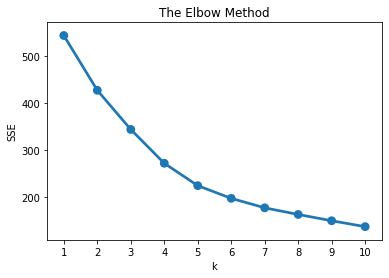

In [396]:
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(group_metric_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [397]:
# K = 4

### 2. Fit the Model

In [398]:
# fit the model

model = KMeans(n_clusters=4)
model.fit(group_metric_normalized)
group_metric["Cluster"] = model.labels_

In [399]:
# get the stats of each cluster

group_metric.groupby('Cluster').agg({
    'Members':'mean',
    'Songs':'mean',
    'Debut Age':'mean',
    'International':'mean'}).round(2)

,Members,Songs,Debut Age,International
Cluster,,,,
0,5.58,28.00,18.70,0.02
1,4.62,7.06,21.15,0.03
2,5.00,8.25,20.01,0.53
3,7.04,7.69,18.41,0.05


### 3. Visualize clusters

In [401]:
# Organize the dataframe
group_metric_normalized.reset_index()

,Group,Members,Songs,Debut Age,International
0,(G)I-DLE,0.113185,-0.836704,0.108551,2.946892
1,100%,-0.339555,0.661871,1.028621,-0.439967
2,14U,3.735106,-0.836704,0.243933,0.043870
3,15&,-1.697775,-0.836704,-2.351652,-0.439967
4,1the9,1.471405,-1.036514,-1.091503,-0.439967
...,...,...,...,...,...
131,ZE:A,1.471405,0.362156,0.320590,-0.439967
132,f(x),-0.792295,-0.037464,-1.078293,2.946892
133,fromis_9,1.471405,-0.636894,-0.451719,-0.439967
134,iKON,0.113185,0.462061,-0.055979,-0.439967


In [402]:
group_metric_normalized["Cluster"] = model.labels_

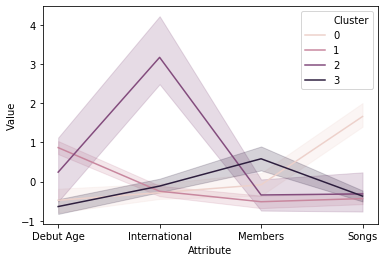

In [403]:
# Melt The Data
group_metric_normalized_melt = pd.melt(group_metric_normalized.reset_index(),
                      id_vars=['Group', 'Cluster'],
                      value_vars=['Members','Songs','Debut Age','International'],
                      var_name='Attribute',
                      value_name='Value')
group_metric_normalized_melt.head()

# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=group_metric_normalized_melt)

### 4. PCA

In [404]:
from sklearn.decomposition import PCA 

In [405]:
pca = PCA(n_components=2)

In [407]:
group_metric_normalized = group_metric_normalized[['Members','Songs','Debut Age','International']]

In [408]:
group_metric_normalized["pc-x"] = pca.fit_transform(group_metric_normalized)[:,0]
group_metric_normalized["pc-y"] = pca.fit_transform(group_metric_normalized)[:,1]

In [409]:
group_metric_normalized

,Members,Songs,Debut Age,International,pc-x,pc-y
Group,,,,,,
(G)I-DLE,0.113185,-0.836704,0.108551,2.946892,1.605503,1.970394
100%,-0.339555,0.661871,1.028621,-0.439967,0.214052,-0.936356
14U,3.735106,-0.836704,0.243933,0.043870,-0.416274,2.936083
15&,-1.697775,-0.836704,-2.351652,-0.439967,-0.694409,-0.685582
1the9,1.471405,-1.036514,-1.091503,-0.439967,-0.680178,1.384123
...,...,...,...,...,...,...
ZE:A,1.471405,0.362156,0.320590,-0.439967,-0.597482,0.647666
f(x),-0.792295,-0.037464,-1.078293,2.946892,0.618101,1.373964
fromis_9,1.471405,-0.636894,-0.451719,-0.439967,-0.502522,1.115873


### 5. Export Output

In [410]:
group_cluster = pd.merge(group_metric.reset_index(),group_metric_normalized.reset_index(),on="Group")

In [411]:
group_cluster = group_cluster[['Group', 'Members_x', 'Songs_x', 'Debut Age_x', 'International_x',
       'Cluster','pc-x', 'pc-y']]

In [358]:
group_cluster.columns = ['Group', 'Members', 'Songs', 'Debut Age', 'International',
       'Cluster','pc-x', 'pc-y']

In [359]:
group_cluster.sample(2)

,Group,Members,Songs,Debut Age,International,Cluster,pc-x,pc-y
110,Stray Kids,8,19,18.289384,0.125,1,-1.063841,0.937026
100,Rainbow,7,9,20.967123,0.000,3,0.316050,0.042901


In [360]:
group_cluster.to_csv("C:/Users/brant/Google Drive/extra study/ Kpop Data Analysis/Untitled Folder/kpop_group_cluster.csv")